In [11]:
import os
from pathlib import Path

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
from psycopg2 import DatabaseError
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

project_root = Path.cwd().resolve().parent
load_dotenv(project_root / ".env")

DATABASE_URL = os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise RuntimeError("DATABASE_URL environment variable is not set. Please update your .env file.")

schema = os.getenv("DB_SCHEMA", "call_data")
engine = create_engine(DATABASE_URL)

query_gold = f"SELECT * FROM {schema}.gold_agent_performance;"
query_silver = f"SELECT * FROM {schema}.silver_call_records;"

try:
    raw_conn = engine.raw_connection()
    try:
        df_gold = pd.read_sql_query(sql=query_gold, con=raw_conn)
    finally:
        raw_conn.close()

    raw_conn = engine.raw_connection()
    try:
        df_silver = pd.read_sql_query(sql=query_silver, con=raw_conn)
    finally:
        raw_conn.close()
except (SQLAlchemyError, DatabaseError) as exc:
    raise RuntimeError("Failed to load data from the database. Verify credentials, schema, and network access.") from exc

display(df_gold.head())

/tmp/ipykernel_28861/2321180807.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gold = pd.read_sql_query(sql=query_gold, con=raw_conn)
/tmp/ipykernel_28861/2321180807.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_silver = pd.read_sql_query(sql=query_silver, con=raw_conn)


,agent_name,total_calls,total_conversions,conversion_rate,total_upsell_amount,avg_upsell_per_call,positive_sentiment_pct,negative_sentiment_pct,last_updated
0,Kevin Martinez,15,0,0.00,0.0,0.00,80.00,0.0,2025-09-25 17:56:24.006014
1,Emily Rodriguez,7,2,28.57,95.0,13.57,85.71,0.0,2025-09-25 17:56:24.006014
2,James Brown,13,4,30.77,45.0,3.46,92.31,0.0,2025-09-25 17:56:24.006014
3,Robert Wilson,10,3,30.00,0.0,0.00,100.00,0.0,2025-09-25 17:56:24.006014
4,David Smith,9,2,22.22,0.0,0.00,66.67,0.0,2025-09-25 17:56:24.006014


In [12]:
total_upsell_revenue = df_gold["total_upsell_amount"].sum()
total_conversions = df_gold["total_conversions"].sum()
total_calls = df_gold["total_calls"].sum()
overall_conversion_rate = total_conversions / total_calls if total_calls else float("nan")
conversion_rate_display = f"{overall_conversion_rate:.2%}" if total_calls else "N/A"

print(f"Total Upsell Revenue: ${total_upsell_revenue:,.2f}")
print(f"Overall Conversion Rate: {conversion_rate_display}")
print(f"Total Calls Handled: {total_calls:,}")

Total Upsell Revenue: $390.00
Overall Conversion Rate: 25.95%
Total Calls Handled: 131


/tmp/ipykernel_28861/910072301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_leaderboard, y="agent_name", x="total_upsell_amount", palette="Blues_d")


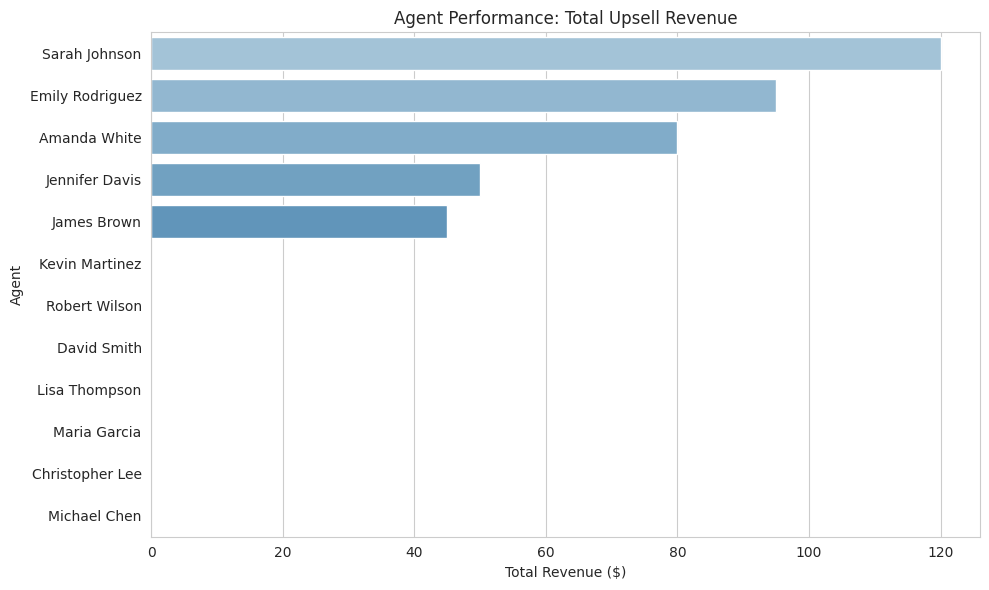

In [13]:
sns.set_style("whitegrid")

df_leaderboard = df_gold.sort_values("total_upsell_amount", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_leaderboard, y="agent_name", x="total_upsell_amount", palette="Blues_d")
plt.title("Agent Performance: Total Upsell Revenue")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Agent")
plt.tight_layout()
plt.show()

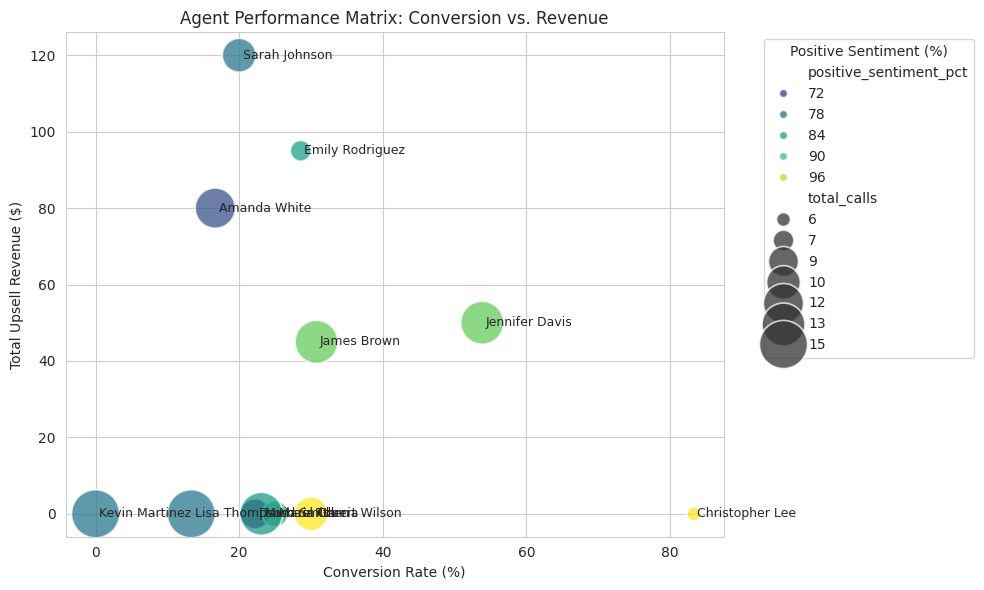

In [14]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
scatter_ax = sns.scatterplot(
    data=df_gold,
    x="conversion_rate",
    y="total_upsell_amount",
    size="total_calls",
    sizes=(100, 1200),
    hue="positive_sentiment_pct",
    palette="viridis",
    alpha=0.75,
    legend="brief"
)

for _, row in df_gold.iterrows():
    plt.text(
        row["conversion_rate"] + 0.5,
        row["total_upsell_amount"],
        row["agent_name"],
        ha="left",
        va="center",
        fontsize=9
    )

plt.title("Agent Performance Matrix: Conversion vs. Revenue")
plt.xlabel("Conversion Rate (%)")
plt.ylabel("Total Upsell Revenue ($)")
plt.legend(title="Positive Sentiment (%)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

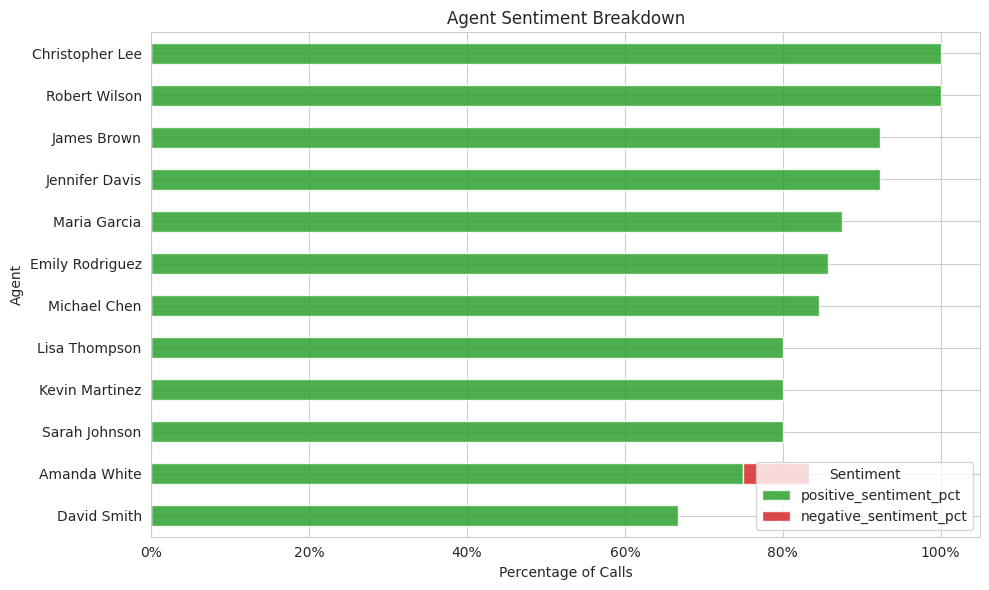

In [15]:
from matplotlib.ticker import PercentFormatter

sentiment_df = (
    df_gold
    .set_index("agent_name")[["positive_sentiment_pct", "negative_sentiment_pct"]]
    .sort_values("positive_sentiment_pct")
)

ax = sentiment_df.plot(
    kind="barh",
    stacked=True,
    color=["#2ca02c", "#d62728"],
    figsize=(10, 6),
    alpha=0.85
)

ax.set_title("Agent Sentiment Breakdown")
ax.set_xlabel("Percentage of Calls")
ax.set_ylabel("Agent")
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.legend(title="Sentiment", loc="lower right")
plt.tight_layout()
plt.show()

In [16]:
def get_transcripts_for_agent(agent_name: str) -> pd.DataFrame:
    required_columns = {"agent_name", "call_timestamp", "transcript_text"}
    missing_columns = required_columns.difference(df_silver.columns)
    if missing_columns:
        raise KeyError(f"df_silver is missing expected columns: {missing_columns}")
    agent_mask = df_silver["agent_name"] == agent_name
    result = df_silver.loc[agent_mask, ["call_timestamp", "transcript_text"]].sort_values("call_timestamp")
    return result.reset_index(drop=True)

lower_performers = df_leaderboard.sort_values("total_upsell_amount", ascending=True)["agent_name"].head(3)
if lower_performers.empty:
    print("No agent records available for drill-down.")
else:
    agent_to_review = lower_performers.iloc[0]
    print(f"Transcripts for coaching - Agent: {agent_to_review}")
    display(get_transcripts_for_agent(agent_to_review))

Transcripts for coaching - Agent: Robert Wilson


,call_timestamp,transcript_text
0,2025-08-28 21:30:05.175485,"Agent: Hello, thank you for calling. How can I..."
1,2025-09-04 05:46:34.414035,"Agent: Hello, thank you for calling. How can I..."
2,2025-09-07 16:22:16.689451,"Agent: Hello, thank you for calling. How can I..."
3,2025-09-08 22:22:03.416473,"Agent: Hello, thank you for calling. How can I..."
4,2025-09-09 02:50:15.951954,"Agent: Hello, thank you for calling. How can I..."
5,2025-09-10 23:15:37.061998,"Agent: Hello, thank you for calling. How can I..."
6,2025-09-18 11:28:20.536369,"Agent: Hello, thank you for calling. How can I..."
7,2025-09-20 23:57:04.154092,"Agent: Hello, thank you for calling. How can I..."
8,2025-09-22 02:41:26.675488,"Agent: Hello, thank you for calling. How can I..."
9,2025-09-22 04:43:47.778308,"Agent: Hello, thank you for calling. How can I..."


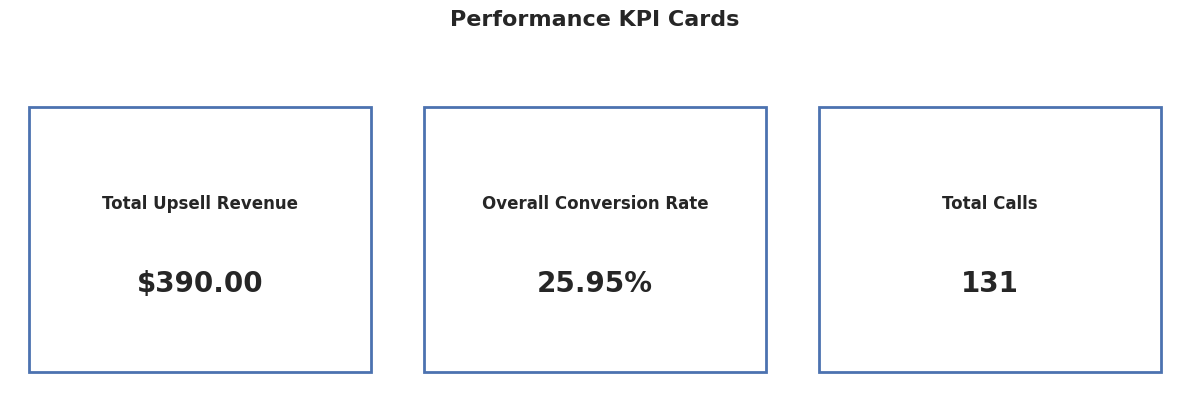

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Performance KPI Cards", fontsize=16, fontweight="bold")

cards = [
    ("Total Upsell Revenue", f"${total_upsell_revenue:,.2f}"),
    ("Overall Conversion Rate", conversion_rate_display),
    ("Total Calls", f"{total_calls:,}")
]

for ax, (title, value) in zip(axes, cards):
    ax.axis("off")
    ax.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9, transform=ax.transAxes, fill=False, linewidth=2, edgecolor="#4c72b0", linestyle="-"))
    ax.text(0.5, 0.62, title, ha="center", va="center", fontsize=12, fontweight="semibold")
    ax.text(0.5, 0.35, value, ha="center", va="center", fontsize=20, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()